# Table of Contents
 <p><div class="lev1"><a href="#Dynamical-and-Topological-Relationships-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Dynamical and Topological Relationships</a></div><div class="lev2"><a href="#Initialize-Environment-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Initialize Environment</a></div><div class="lev2"><a href="#Generate-List-of-Data-1.2"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>Generate List of Data</a></div><div class="lev2"><a href="#Modules-vs-Subgraphs-1.3"><span class="toc-item-num">1.3&nbsp;&nbsp;</span>Modules vs Subgraphs</a></div><div class="lev2"><a href="#Inter/Intra-Module-Connectivity-of-Subgraphs-1.4"><span class="toc-item-num">1.4&nbsp;&nbsp;</span>Inter/Intra Module Connectivity of Subgraphs</a></div><div class="lev2"><a href="#Generate-the-Module-Sensitivity-Index-1.5"><span class="toc-item-num">1.5&nbsp;&nbsp;</span>Generate the Module-Sensitivity Index</a></div><div class="lev2"><a href="#Temporal-Expression-of-Module-Sensitive-Subgraphs-1.6"><span class="toc-item-num">1.6&nbsp;&nbsp;</span>Temporal Expression of Module-Sensitive Subgraphs</a></div><div class="lev3"><a href="#Relate-Module-Reconfiguration-to-Subgraph-Reconfiguration-1.6.1"><span class="toc-item-num">1.6.1&nbsp;&nbsp;</span>Relate Module-Reconfiguration to Subgraph-Reconfiguration</a></div><div class="lev2"><a href="#Subgraph-Topography-1.7"><span class="toc-item-num">1.7&nbsp;&nbsp;</span>Subgraph Topography</a></div><div class="lev3"><a href="#Relate-Subgraph-Connection-Strength-to-Connection-Distance-1.7.1"><span class="toc-item-num">1.7.1&nbsp;&nbsp;</span>Relate Subgraph Connection Strength to Connection Distance</a></div><div class="lev3"><a href="#Topographical-Sensitivity-1.7.2"><span class="toc-item-num">1.7.2&nbsp;&nbsp;</span>Topographical Sensitivity</a></div><div class="lev3"><a href="#Compute-Subgraph-Dynamics-1.7.3"><span class="toc-item-num">1.7.3&nbsp;&nbsp;</span>Compute Subgraph Dynamics</a></div><div class="lev3"><a href="#Relate-Subgraph-Dynamics-to-Topographical-Sensitivity-1.7.4"><span class="toc-item-num">1.7.4&nbsp;&nbsp;</span>Relate Subgraph Dynamics to Topographical Sensitivity</a></div>

# Dynamical and Topological Relationships

## Initialize Environment

In [13]:
try:
    %load_ext autoreload
    %autoreload 2
    
except:
    print 'NOT IPYTHON'

from __future__ import division
from IPython.display import display

import os
import sys
import glob
import json

import numpy as np
import pandas as pd
import scipy.stats as stats
import h5py

import matplotlib.pyplot as plt
import matplotlib.patches as patches
from matplotlib import rcParams
import fig_plotting
rcParams = fig_plotting.update_rcparams(rcParams)

os.chdir('../')
import Codebase
os.chdir('./Analysis Notebooks/')

path_CoreData = '/Users/akhambhati/Remotes/CORE.fMRI_multiband.mmattar/restdata'
path_PeriphData = '/Users/akhambhati/Remotes/RSRCH.NMF_Subnetworks'
path_ModData = path_PeriphData + '/e02-DynFuncModule'
path_SubData = path_PeriphData + '/e03-DynFuncSubgraph'
path_ExpData = path_PeriphData + '/e04-CmpModuleSubgraph'

for path in [path_CoreData, path_PeriphData, path_ModData, path_SubData, path_ExpData]:
    if not os.path.exists(path):
        print('Path: {}, does not exist'.format(path))
        os.makedirs(path)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Generate List of Data

In [14]:
subj_mod_ids = np.unique([full_subj_path.split('/')[-1].split('.')[0]
                          for full_subj_path in glob.iglob('{}/*.consensus_module.npz'.format(path_ModData))])
subj_sub_ids = np.unique([full_subj_path.split('/')[-1].split('.')[0]
                          for full_subj_path in glob.iglob('{}/*.consensus_subgraph.npz'.format(path_SubData))])
subj_cfg_ids = np.unique([full_subj_path.split('/')[-1].split('.')[0]
                          for full_subj_path in glob.iglob('{}/*.cfg_matr.npz'.format(path_SubData))])

if not len(np.intersect1d(subj_mod_ids, subj_sub_ids)) == len(subj_mod_ids):
    raise Exception('Subject files mismatched')
if not len(np.intersect1d(subj_mod_ids, subj_cfg_ids)) == len(subj_mod_ids):
    raise Exception('Subject files mismatched')
    
subj_dict = {}
for subj in subj_mod_ids:
    subj_dict[subj] = {'module_path': '{}/{}.consensus_module.npz'.format(path_ModData, subj),
                       'subgraph_path': '{}/{}.consensus_subgraph.npz'.format(path_SubData, subj),
                       'cfg_path': '{}/{}.cfg_matr.npz'.format(path_SubData, subj)}

## Modules vs Subgraphs

 -- Processing: A010615C


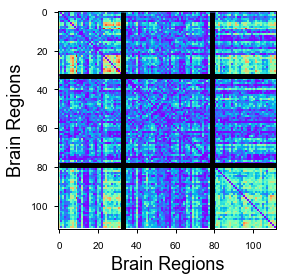

In [15]:
%matplotlib inline

n_subj = len(subj_dict.keys())
for subj_i, subj in enumerate(['A010615C']): #enumerate(subj_dict.iterkeys()):
    print(" -- Processing: {}".format(subj))
    
    data_cfg = np.load(subj_dict[subj]['cfg_path'], mmap_mode='r')
    data_sub = np.load(subj_dict[subj]['subgraph_path'], mmap_mode='r')
    data_mod = np.load(subj_dict[subj]['module_path'], mmap_mode='r')
    
    
    module_assign = data_mod['module_assign']
    cfg_matr = data_cfg['cfg_matr']
    fac_subgraph = data_sub['fac_subnet']
    fac_coef = data_sub['fac_coef']
        
    n_win = module_assign.shape[0]
    n_node = module_assign.shape[1]
    n_fac = fac_subgraph.shape[0]
    n_conn = fac_subgraph.shape[1]
    
    # Set window index and get modules
    iw = 44
    srt_module = np.argsort(module_assign[iw, :])
    ix, iy = np.meshgrid(srt_module, srt_module)
    max_fac = np.argsort(fac_coef[:, iw])[-1]
    
    # Plot sort subgraph
    plt.figure()
    ax = plt.subplot(111)         
    subg_adj = Codebase.Networks.configuration.convert_conn_vec_to_adj_matr(fac_subgraph[max_fac, :])
    ax.matshow(subg_adj[ix, iy], cmap='rainbow')
    
    # Plot module dividers
    mod_cutoff_ix = np.unique(np.sort(module_assign[iw, :]), return_index=True)[1][1:]
    plt.vlines(mod_cutoff_ix, 0, n_node, color='k', linewidth=5.0)
    plt.hlines(mod_cutoff_ix, 0, n_node, color='k', linewidth=5.0)    

    # Axis Settings
    ax.yaxis.set_ticks_position('left')
    ax.xaxis.set_ticks_position('bottom')
    ax.set_xlabel('Brain Regions')        
    ax.set_ylabel('Brain Regions')

    #plt.savefig('./e04-Figures/{}-Module_Subgraph-Contrast-TW_{}.svg'.format(subj, iw))
    plt.show()
    plt.close()

## Inter/Intra Module Connectivity of Subgraphs

 -- Processing: h010615p
 -- Processing: j032315w
 -- Processing: A010615C
 -- Processing: b031615b
 -- Processing: a012615k
 -- Processing: d011215h
 -- Processing: a022315k
 -- Processing: b020315b
 -- Processing: k031615k
 -- Processing: m020915s
 -- Processing: s031015v
 -- Processing: n032315o
 -- Processing: H020915Z
 -- Processing: m011215c
 -- Processing: a020315s
 -- Processing: h022315k
 -- Processing: m030215g
 -- Processing: M030215R
 -- Processing: j030915h
 -- Processing: b012615o
Intra-Module Subgraph Connectivity - Intra-Module Null Subgraph Connectivity: 8.32586192175, 1.52357685939e-16
Intra-Module Subgraph Connectivity - Inter-Module Subgraph Connectivity: 4.31013602587, 0.000111355522499
Inter-Module Subgraph Connectivity - Inter-Module Null Subgraph Connectivity: -2.96841024107, 0.00302869570949
Intra-Module Null Subgraph Connectivity - Inter-Module Null Subgraph Connectivity: -27.6719103471, 2.31166956804e-154


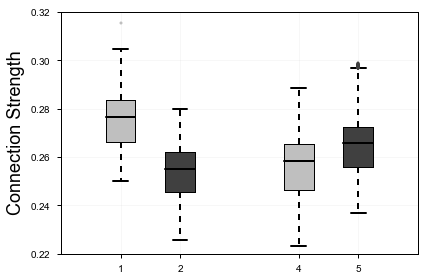

In [16]:
%matplotlib inline

fac_coef_pop = []
fac_subgraph_pop = []
n_null = 100

n_subj = len(subj_dict.keys())
for subj_i, subj in enumerate(subj_dict.iterkeys()):
    print(" -- Processing: {}".format(subj))
    
    data_sub = np.load(subj_dict[subj]['subgraph_path'], mmap_mode='r')
    data_mod = np.load(subj_dict[subj]['module_path'], mmap_mode='r')
    
    module_assign = data_mod['module_assign']
    fac_subgraph = data_sub['fac_subnet']
    fac_subgraph_pop.append(fac_subgraph)    
    fac_coef = data_sub['fac_coef']
    fac_coef_pop.append(fac_coef)
        
    n_win = module_assign.shape[0]
    n_node = module_assign.shape[1]
    n_fac = fac_subgraph.shape[0]
    n_conn = fac_subgraph.shape[1]
    
    if subj_i == 0:
        intra_module_conn_pop = np.nan*np.zeros((n_subj, n_fac, n_win))
        inter_module_conn_pop = np.nan*np.zeros((n_subj, n_fac, n_win))
        intra_module_conn_pop_null = np.nan*np.zeros((n_subj, n_null, n_fac, n_win))
        inter_module_conn_pop_null = np.nan*np.zeros((n_subj, n_null, n_fac, n_win))

    
    # Real Intra/Inter Module Subgraph Connectivity
    intra_module_conn = []
    inter_module_conn = []
    for ii in xrange(n_fac):
        norm_subgraph = fac_subgraph[ii, :] / fac_subgraph[ii, :].max()
        subgraph_adj = Codebase.Networks.configuration.convert_conn_vec_to_adj_matr(norm_subgraph)
        
        for iw in xrange(n_win):
            module_id = np.unique(module_assign[iw, :])
            
            if len(module_id) == 1:
                intra_module_conn_pop[subj_i, ii, iw] = 0
                inter_module_conn_pop[subj_i, ii, iw] = 0
            else:            
                for m_id in module_id:
                    in_nodes = np.flatnonzero(module_assign[iw, :] == m_id)
                    out_nodes = np.setdiff1d(np.arange(n_node), in_nodes)

                    in_1, in_2 = np.meshgrid(in_nodes, in_nodes)
                    intra_module_conn.append(np.mean(subgraph_adj[in_1, in_2]))

                    in_1, out_2 = np.meshgrid(in_nodes, out_nodes)                
                    inter_module_conn.append(np.mean(subgraph_adj[in_1, out_2]))
                intra_module_conn_pop[subj_i, ii, iw] = np.mean(intra_module_conn)
                inter_module_conn_pop[subj_i, ii, iw] = np.mean(inter_module_conn)            
    
    # Null Intra/Inter Module Connectivity
    for nn in xrange(n_null):
        intra_module_conn = []
        inter_module_conn = [] 
        for ii in xrange(n_fac):            
            norm_subgraph = fac_subgraph[ii, :] / fac_subgraph[ii, :].max()
            subgraph_adj = Codebase.Networks.configuration.convert_conn_vec_to_adj_matr(norm_subgraph)

            for iw in xrange(n_win):
                null_module_assign = np.random.permutation(module_assign[iw, :])
                module_id = np.unique(null_module_assign)         
            
                if len(module_id) == 1:
                    intra_module_conn_pop_null[subj_i, nn, ii, iw] = 0
                    inter_module_conn_pop_null[subj_i, nn, ii, iw] = 0
                else:            
                    for m_id in module_id:
                        in_nodes = np.flatnonzero(null_module_assign == m_id)
                        out_nodes = np.setdiff1d(np.arange(n_node), in_nodes)

                        in_1, in_2 = np.meshgrid(in_nodes, in_nodes)
                        intra_module_conn.append(np.mean(subgraph_adj[in_1, in_2]))

                        in_1, out_2 = np.meshgrid(in_nodes, out_nodes)
                        inter_module_conn.append(np.mean(subgraph_adj[in_1, out_2]))
                    intra_module_conn_pop_null[subj_i, nn, ii, iw] = np.mean(intra_module_conn)
                    inter_module_conn_pop_null[subj_i, nn, ii, iw] = np.mean(inter_module_conn)      

intra_module_conn_subj = np.nanmean(np.nanmean(intra_module_conn_pop, axis=-1), axis=-1)
inter_module_conn_subj = np.nanmean(np.nanmean(inter_module_conn_pop, axis=-1), axis=-1)
intra_module_conn_subj_null = np.nanmean(np.nanmean(intra_module_conn_pop_null, axis=-1), axis=-1).reshape(-1)
inter_module_conn_subj_null = np.nanmean(np.nanmean(inter_module_conn_pop_null, axis=-1), axis=-1).reshape(-1)
                    
cases_list = [('Intra-Module Subgraph Connectivity', intra_module_conn_subj),
              ('Intra-Module Null Subgraph Connectivity', intra_module_conn_subj_null),
              ('Inter-Module Subgraph Connectivity', inter_module_conn_subj),
              ('Inter-Module Null Subgraph Connectivity', inter_module_conn_subj_null)]

pairs = [[cases_list[0], cases_list[1]],
         [cases_list[0], cases_list[2]],
         [cases_list[2], cases_list[3]],
         [cases_list[1], cases_list[3]]]

for p_i, pair in enumerate(pairs):
    t, p = stats.ttest_ind(pair[0][1], pair[1][1])    
    print('{} - {}: {}, {}'.format(pair[0][0], pair[1][0], t, p))


# Construct result figure
plt.figure()
ax = plt.subplot(111)
bplot = ax.boxplot([cases_list[0][1], cases_list[1][1],
                    cases_list[2][1], cases_list[3][1]],
                   positions=[1, 2, 4, 5], patch_artist=True)
fig_plotting.set_box_color(bplot, 'k', [[0.75, 0.75, 0.75],
                                        [0.25, 0.25, 0.25],
                                        [0.75, 0.75, 0.75],
                                        [0.25, 0.25, 0.25]])
ax.set_xlim([0, 6])

# Axis Settings
ax.yaxis.set_ticks_position('left')
ax.xaxis.set_ticks_position('bottom')
ax.set_ylabel('Connection Strength')

#plt.savefig('./e04-Figures/IntraInter_SubgraphModule_Conn.svg'.format(p_i+1))
plt.show()
plt.close()      

## Generate the Module-Sensitivity Index

16-Ttest_indResult(statistic=21.078707491992734, pvalue=2.6337908149392034e-89)
16-Ttest_indResult(statistic=31.249798387507262, pvalue=3.4611081153039883e-175)
16-Ttest_indResult(statistic=37.604029696195077, pvalue=5.3933690119425324e-235)
16-Ttest_indResult(statistic=42.07753570023916, pvalue=2.535838971373982e-278)
16-Ttest_indResult(statistic=44.420397342425353, pvalue=3.6083692742371028e-301)
16-Ttest_indResult(statistic=46.330325050689353, pvalue=8.3121604256331319e-320)
16-Ttest_indResult(statistic=48.67825104891164, pvalue=0.0)
16-Ttest_indResult(statistic=50.409981613410906, pvalue=0.0)
16-Ttest_indResult(statistic=46.80609419999751, pvalue=0.0)
16-Ttest_indResult(statistic=52.509020767635, pvalue=0.0)
16-Ttest_indResult(statistic=54.162569193959754, pvalue=0.0)
16-Ttest_indResult(statistic=55.515225969665416, pvalue=0.0)
16-Ttest_indResult(statistic=57.821006963213492, pvalue=0.0)
16-Ttest_indResult(statistic=59.317419664904364, pvalue=0.0)
16-Ttest_indResult(statistic=62.47

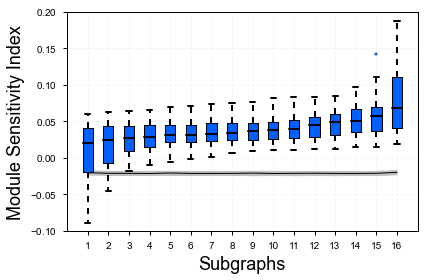

F_onewayResult(statistic=8.4231502316011948, pvalue=4.1789098076063511e-16)


"\n# Compute subgraph/time average measure\nmodule_sensitivity_pop_flat = np.nanmean(np.nanmean(module_sensitivity_pop, axis=-1), axis=-1)\nmodule_sensitivity_pop_null_flat = np.nanmean(np.nanmean(np.nanmean(module_sensitivity_pop_null, axis=-1), axis=-1), axis=-1)\n\nprint(stats.ttest_rel(module_sensitivity_pop_flat, module_sensitivity_pop_null_flat))\n\n# Construct result figure\nplt.figure()\nax = plt.subplot(111)\nbplot = ax.boxplot([module_sensitivity_pop_flat,\n                    module_sensitivity_pop_null_flat],\n                   positions=[1, 2], patch_artist=True)\nfig_plotting.set_box_color(bplot, 'k', [[0.75, 0.75, 0.75],\n                                        [0.25, 0.25, 0.25]])\n\n# Axis Settings\nax.yaxis.set_ticks_position('left')\nax.xaxis.set_ticks_position('bottom')\nax.set_ylabel('Time-Average\nModule Sensitivity Index')\n\nplt.savefig('./e04-Figures/Module_Sensitivity_Index.svg')                           \nplt.show()\nplt.close()   \n"

In [24]:
# Dimensions: (n_subj, n_fac, n_win)
msi_pop = (intra_module_conn_pop - inter_module_conn_pop) / \
          (intra_module_conn_pop + inter_module_conn_pop)
# Dimensions: (n_subj, n_null, n_fac, n_win)    
msi_pop_null = (intra_module_conn_pop_null - inter_module_conn_pop_null) / \
               (intra_module_conn_pop_null + inter_module_conn_pop_null)
n_subj, n_null, n_fac, n_win = msi_pop_null.shape


msi_avg = np.nanmean(msi_pop, axis=-1)
msi_avg_ord = np.sort(msi_avg, axis=1)
msi_avg_ord_ix = np.argsort(msi_avg, axis=1)

msi_avg_null = np.nanmean(msi_pop_null, axis=-1)
msi_null_dist = np.zeros((3, n_fac))
for fac_ix in xrange(n_fac):
    null_distrib = msi_avg_null[xrange(n_subj), :, msi_avg_ord_ix[:, fac_ix]].reshape(-1)
    msi_null_dist[0, fac_ix] = np.percentile(null_distrib, 25)
    msi_null_dist[1, fac_ix] = np.percentile(null_distrib, 50)
    msi_null_dist[2, fac_ix] = np.percentile(null_distrib, 75)  
    
    print('{}-{}'.format(ii+1, stats.ttest_ind(msi_avg_ord[:, fac_ix],
                                               null_distrib)))
    

plt.figure()
ax = plt.subplot(111)

ax.plot(np.arange(1, 17), msi_null_dist[1, :], color='k', linewidth=1.0)
ax.fill_between(np.arange(1, 17),
                y1=msi_null_dist[0, :],
                y2=msi_null_dist[2, :],
                color=[0.75, 0.75, 0.75])

bplot = ax.boxplot(msi_avg_ord, patch_artist=True)
fig_plotting.set_box_color(bplot, 'k', [[0.0, 0.375, 1.0] for ii in xrange(n_fac)])

# Axis Settings
ax.set_xlim([0, 17])
ax.yaxis.set_ticks_position('left')
ax.xaxis.set_ticks_position('bottom')
ax.set_ylabel('Module Sensitivity Index');
ax.set_xlabel('Subgraphs');

plt.savefig('./e04-Figures/Module_Sensitivity_Index.svg')                           
plt.show()
plt.close()   
    
    
print(stats.f_oneway(msi_avg_ord[:,0], msi_avg_ord[:,1], msi_avg_ord[:,2], msi_avg_ord[:,3],
                     msi_avg_ord[:,4], msi_avg_ord[:,5], msi_avg_ord[:,6], msi_avg_ord[:,7],
                     msi_avg_ord[:,8], msi_avg_ord[:,9], msi_avg_ord[:,10], msi_avg_ord[:,11],
                     msi_avg_ord[:,12], msi_avg_ord[:,13], msi_avg_ord[:,14], msi_avg_ord[:,15]))

"""
# Compute subgraph/time average measure
module_sensitivity_pop_flat = np.nanmean(np.nanmean(module_sensitivity_pop, axis=-1), axis=-1)
module_sensitivity_pop_null_flat = np.nanmean(np.nanmean(np.nanmean(module_sensitivity_pop_null, axis=-1), axis=-1), axis=-1)

print(stats.ttest_rel(module_sensitivity_pop_flat, module_sensitivity_pop_null_flat))

# Construct result figure
plt.figure()
ax = plt.subplot(111)
bplot = ax.boxplot([module_sensitivity_pop_flat,
                    module_sensitivity_pop_null_flat],
                   positions=[1, 2], patch_artist=True)
fig_plotting.set_box_color(bplot, 'k', [[0.75, 0.75, 0.75],
                                        [0.25, 0.25, 0.25]])

# Axis Settings
ax.yaxis.set_ticks_position('left')
ax.xaxis.set_ticks_position('bottom')
ax.set_ylabel('Time-Average\nModule Sensitivity Index')

plt.savefig('./e04-Figures/Module_Sensitivity_Index.svg')                           
plt.show()
plt.close()   
"""

## Temporal Expression of Module-Sensitive Subgraphs

1-Ttest_indResult(statistic=-12.307030785102249, pvalue=1.2902172079687986e-33)
2-Ttest_indResult(statistic=-8.0890475529313655, pvalue=1.0267998738263174e-15)
3-Ttest_indResult(statistic=-6.2657212324427114, pvalue=4.5237635283505341e-10)
4-Ttest_indResult(statistic=-4.799982439288466, pvalue=1.7032996189447928e-06)
5-Ttest_indResult(statistic=-3.4339562449736714, pvalue=0.00060685729049400562)
6-Ttest_indResult(statistic=-2.5918094937568275, pvalue=0.0096161278661567959)
7-Ttest_indResult(statistic=-1.27156623562738, pvalue=0.2036738086583248)
8-Ttest_indResult(statistic=-0.216840696548878, pvalue=0.82835441395057641)
9-Ttest_indResult(statistic=0.92532308753601367, pvalue=0.35490851103447041)
10-Ttest_indResult(statistic=1.952888446340741, pvalue=0.050970869571321714)
11-Ttest_indResult(statistic=3.0468779295914432, pvalue=0.0023422796505894509)
12-Ttest_indResult(statistic=4.6489613848907512, pvalue=3.5519605437452405e-06)
13-Ttest_indResult(statistic=5.5105006381414317, pvalue=4.0

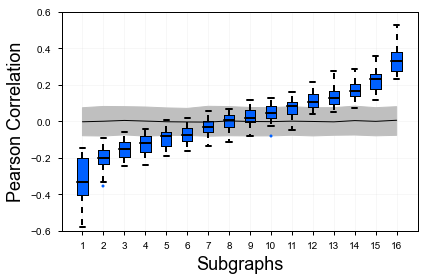

In [21]:
module_sensitivity_coef = np.zeros((n_subj, n_fac))
module_sensitivity_coef_null = np.zeros((n_subj, n_null, n_fac))

for subj_i in xrange(n_subj):
    for fac_i in xrange(n_fac):
        norm_coef = fac_coef_pop[subj_i][fac_i, :] / fac_coef_pop[subj_i][fac_i, :].max()
        good_tw = np.flatnonzero(~np.isnan(msi_pop[subj_i, fac_i, :]))
        rho, pv = stats.pearsonr(msi_pop[subj_i, fac_i, good_tw], norm_coef[good_tw])
        if np.isnan(rho):
            continue
        module_sensitivity_coef[subj_i, fac_i] = rho
        
        for null_i in xrange(n_null):
            null_coef = np.random.permutation(norm_coef)
            rho, pv = stats.pearsonr(msi_pop[subj_i, fac_i, good_tw], null_coef[good_tw])
            if np.isnan(rho):
                continue
            module_sensitivity_coef_null[subj_i, null_i, fac_i] = rho
        
module_sensitivity_coef_sorted = np.sort(module_sensitivity_coef, axis=1)
module_sensitivity_coef_null_sorted = np.sort(module_sensitivity_coef_null, axis=1).reshape(n_subj*n_null, n_fac)
module_sensitivity_coef_ord = np.argsort(module_sensitivity_coef, axis=1)

# Plot Correlation Between Module-Sensitivity Index and Normalized Temporal Coefficient
plt.figure()
ax = plt.subplot(111)

ax.plot(np.arange(1, 17),
        np.percentile(module_sensitivity_coef_null_sorted, 50, axis=0),
        color='k', linewidth=1.0)
ax.fill_between(np.arange(1, 17),
                y1=np.percentile(module_sensitivity_coef_null_sorted, 25, axis=0),
                y2=np.percentile(module_sensitivity_coef_null_sorted, 75, axis=0),
                color=[0.75, 0.75, 0.75])

for ii in xrange(n_fac):
    print('{}-{}'.format(ii+1, stats.ttest_ind(module_sensitivity_coef_sorted[:, ii],
                                               module_sensitivity_coef_null_sorted[:, ii])))

clr_list = []
for ii in xrange(n_fac):
    clr_list.append([0.0, 0.375, 1.0])
bplot = ax.boxplot(module_sensitivity_coef_sorted, patch_artist=True);
fig_plotting.set_box_color(bplot, 'k', clr_list)

# Axis Settings
ax.set_xlim([0, 17])
ax.yaxis.set_ticks_position('left')
ax.xaxis.set_ticks_position('bottom')
ax.set_ylabel('Pearson Correlation');
ax.set_xlabel('Subgraphs');

#plt.savefig('./e04-Figures/Module_Sensitivity_Index-TemporalPCorr.svg')
plt.show()
plt.close()              

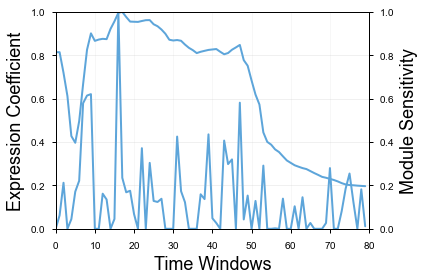

In [300]:
s_id = 2
opt_fac = module_sensitivity_coef_ord[s_id,:][-1]

### Plot Example Good and Bad Module sensitivity
plt.figure()
ax = plt.subplot(111)
ax.plot(fac_coef_pop[s_id][opt_fac, :] / fac_coef_pop[s_id][opt_fac, :].max())

# Axis Settings
ax.xaxis.set_ticks_position('bottom')
ax.set_xlabel('Time Windows');
ax.set_ylabel('Expression Coefficient');

ax1 = ax.twinx()
ax1.plot(module_sensitivity_pop[s_id, opt_fac,:] / module_sensitivity_pop[s_id, opt_fac, :].max() )

# Axis Settings
ax1.yaxis.set_ticks_position('right')
ax1.set_yticks([0.0, 0.2, 0.4, 0.6, 0.8, 1.0])
ax1.set_ylabel('Module Sensitivity');

#plt.savefig('./e04-Figures/{}-Subgraph_{}-Module_Sensitivity_Index-TemporalCoef.svg'.format(subj_dict.keys()[s_id],
#                                                                                           opt_fac))
plt.show()
plt.close()              

### Relate Module-Reconfiguration to Subgraph-Reconfiguration

 -- Processing: h010615p
 -- Processing: j032315w
 -- Processing: A010615C
 -- Processing: b031615b
 -- Processing: a012615k
 -- Processing: d011215h
 -- Processing: a022315k
 -- Processing: b020315b
 -- Processing: k031615k
 -- Processing: m020915s
 -- Processing: s031015v
 -- Processing: n032315o
 -- Processing: H020915Z
 -- Processing: m011215c
 -- Processing: a020315s
 -- Processing: h022315k
 -- Processing: m030215g
 -- Processing: M030215R
 -- Processing: j030915h
 -- Processing: b012615o
MSI High: Temporal Energy: r=-0.445020551709, p=0.0492779530089
MSI Low: Temporal Energy: r=-0.163432576063, p=0.491148994044


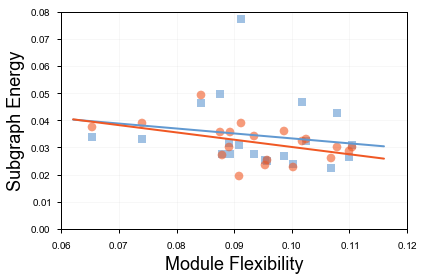

MSI High: Temporal Skew: r=0.555078412071, p=0.0110699427984
MSI Low: Temporal Skew: r=-0.129108406608, p=0.587479752789


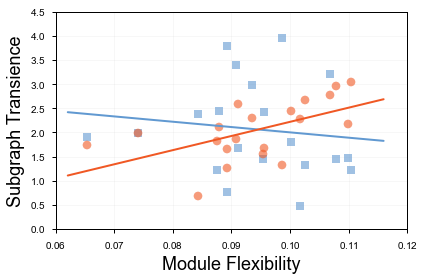

MSI High: Temporal Energy and Skew: r=-0.344053698155, p=0.137446551875
MSI Low: Temporal Energy and Skew: r=-0.357717609369, p=0.121498763502


In [358]:
%matplotlib inline               

n_subj = len(subj_dict.keys())
n_null = 1000

red = [240./255, 88./255, 36./255]
blue = [97./255, 153./255, 209./255]

mod_flex_pop = np.zeros(n_subj)
msi_high_skew_pop = np.zeros(n_subj)
msi_low_skew_pop = np.zeros(n_subj)
msi_high_energy_pop = np.zeros(n_subj)
msi_low_energy_pop = np.zeros(n_subj)

for subj_i, subj in enumerate(subj_dict.iterkeys()):
    print(" -- Processing: {}".format(subj))
        
    data_cfg = np.load(subj_dict[subj]['cfg_path'], mmap_mode='r')
    data_sub = np.load(subj_dict[subj]['subgraph_path'], mmap_mode='r')
    data_mod = np.load(subj_dict[subj]['module_path'], mmap_mode='r')
    
    module_assign = data_mod['module_assign']
    cfg_matr = data_cfg['cfg_matr']
    fac_subgraph = data_sub['fac_subnet']
    fac_coef = data_sub['fac_coef']
        
    n_win = module_assign.shape[0]
    n_node = module_assign.shape[1]
    n_fac = fac_subgraph.shape[0]
    n_conn = fac_subgraph.shape[1]
    
    # Module flexibility
    mod_flex_pop[subj_i] = np.mean(np.mean(np.abs(np.diff(module_assign, axis=0)) > 0, axis=0))
    
    # Temporal transience and energy
    fac_coef_norm = fac_coef / fac_coef.max()
    msi_high_ix = np.argsort(np.nanmean(msi_pop[subj_i, ...], axis=-1))[-1]
    msi_low_ix = np.argsort(np.nanmean(msi_pop[subj_i, ...], axis=-1))[0]
    
    msi_high_energy_pop[subj_i] = np.mean(fac_coef_norm[msi_high_ix, :] ** 2)
    msi_low_energy_pop[subj_i] = np.mean(fac_coef_norm[msi_low_ix, :] ** 2)    
    msi_high_skew_pop[subj_i] = stats.skew(fac_coef_norm[msi_high_ix, :]) 
    msi_low_skew_pop[subj_i] = stats.skew(fac_coef_norm[msi_low_ix, :]) 
    

# Relationship to temporal energy
m_high_energy, b_high_energy, rho_high_energy, pv_high_energy, _ = stats.linregress(mod_flex_pop, msi_high_energy_pop)
m_low_energy, b_low_energy, rho_low_energy, pv_low_energy, _ = stats.linregress(mod_flex_pop, msi_low_energy_pop)
print('MSI High: Temporal Energy: r={}, p={}'.format(rho_high_energy, pv_high_energy))
print('MSI Low: Temporal Energy: r={}, p={}'.format(rho_low_energy, pv_low_energy))

plt.figure(); 
ax = plt.subplot(111);
x = np.array([np.min(mod_flex_pop)*0.95, np.max(mod_flex_pop)*1.05])
ax.scatter(mod_flex_pop, msi_low_energy_pop, color=blue, marker='s', alpha=0.6, s=75.0, lw=0)
ax.plot(x, m_low_energy*x + b_low_energy, color=blue)
ax.scatter(mod_flex_pop, msi_high_energy_pop, color=red, marker='o', alpha=0.6, s=75.0, lw=0)
ax.plot(x, m_high_energy*x + b_high_energy, color=red)

# Axis Settings
ax.set_xlim([0.06, 0.12])
ax.set_ylim([0, 0.08])
ax.yaxis.set_ticks_position('left')
ax.xaxis.set_ticks_position('bottom')
ax.set_ylabel('Subgraph Energy');
ax.set_xlabel('Module Flexibility');

plt.savefig('./e04-Figures/Module_Flexibility-Subgraph_Energy.svg')
plt.show()
plt.close()              

# Relationship to temporal skew
m_high_skew, b_high_skew, rho_high_skew, pv_high_skew, _ = stats.linregress(mod_flex_pop, msi_high_skew_pop)
m_low_skew, b_low_skew, rho_low_skew, pv_low_skew, _ = stats.linregress(mod_flex_pop, msi_low_skew_pop)
print('MSI High: Temporal Skew: r={}, p={}'.format(rho_high_skew, pv_high_skew))
print('MSI Low: Temporal Skew: r={}, p={}'.format(rho_low_skew, pv_low_skew))

plt.figure(); 
ax = plt.subplot(111);
x = np.array([np.min(mod_flex_pop)*0.95, np.max(mod_flex_pop)*1.05])
ax.scatter(mod_flex_pop, msi_low_skew_pop, color=blue, marker='s', alpha=0.6, s=75.0, lw=0)
ax.plot(x, m_low_skew*x + b_low_skew, color=blue)
ax.scatter(mod_flex_pop, msi_high_skew_pop, color=red, marker='o', alpha=0.6, s=75.0, lw=0)
ax.plot(x, m_high_skew*x + b_high_skew, color=red)

# Axis Settings
ax.set_xlim([0.06, 0.12])
ax.yaxis.set_ticks_position('left')
ax.xaxis.set_ticks_position('bottom')
ax.set_ylabel('Subgraph Transience');
ax.set_xlabel('Module Flexibility');

plt.savefig('./e04-Figures/Module_Flexibility-Subgraph_Skew.svg')
plt.show()
plt.close()              

# Relationship between temporal energy and skew
m_high_skew, b_high_skew, rho_high_skew, pv_high_skew, _ = stats.linregress(msi_high_energy_pop, msi_high_skew_pop)
m_low_skew, b_low_skew, rho_low_skew, pv_low_skew, _ = stats.linregress(msi_low_energy_pop, msi_low_skew_pop)

print('MSI High: Temporal Energy and Skew: r={}, p={}'.format(rho_high_skew, pv_high_skew))
print('MSI Low: Temporal Energy and Skew: r={}, p={}'.format(rho_low_skew, pv_low_skew))

## Subgraph Topography

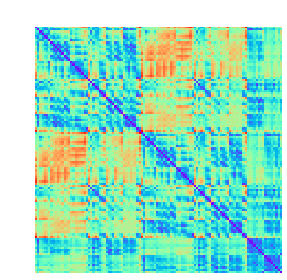

In [6]:
# Generate Node Distance Matrix
df = pd.read_csv('{}/Atlas/HOA112_Labels.csv'.format(path_CoreData))
n_node = len(df)

dist_matr = np.zeros((n_node, n_node))
ix, iy = np.mgrid[:n_node, :n_node]

dX = np.array(df.X)
dY = np.array(df.Y)
dZ = np.array(df.Z)

dist_matr[ix, iy] = np.sqrt((dX[ix]-dX[iy])**2 + 
                            (dY[ix]-dY[iy])**2 +
                            (dZ[ix]-dZ[iy])**2)
dist_matr /= dist_matr.max()

plt.figure()        
ax = plt.subplot(111)
mat = ax.matshow(dist_matr, cmap='rainbow')
#plt.colorbar(mat, ax=ax)

# Axis Settings
ax.set_axis_off()
#ax.set_title('Inter-Region Distance')

plt.savefig('./e04-Figures/Topography-InterRegion_Distance.svg')
plt.show()
plt.close()          

### Relate Subgraph Connection Strength to Connection Distance

In [7]:
%matplotlib inline
n_null = 1000

n_subj = len(subj_dict.keys())
for subj_i, subj in enumerate(subj_dict.iterkeys()):
    print(" -- Processing: {}".format(subj))
    
    data_sub = np.load(subj_dict[subj]['subgraph_path'], mmap_mode='r')
    
    fac_subgraph = data_sub['fac_subnet']
    fac_coef = data_sub['fac_coef']
        
    n_win = module_assign.shape[0]
    n_node = module_assign.shape[1]
    n_fac = fac_subgraph.shape[0]
    n_conn = fac_subgraph.shape[1]

    triu_ix, triu_iy = np.triu_indices(n_node, k=1)
    conn_dist = dist_matr[triu_ix, triu_iy]    
    
    if subj_i == 0:
        topo_sens_pop = np.nan*np.zeros((n_subj, n_fac))
        topo_sens_pop_null = np.nan*np.zeros((n_subj, n_null, n_fac))        

    # Correlation between Subgraph and Distance Matrix
    for f_id in xrange(n_fac):
        fac_subgraph_norm = fac_subgraph[f_id, :] / fac_subgraph[f_id, :].max()
        rho, pval = stats.pearsonr(conn_dist, fac_subgraph_norm)
        topo_sens_pop[subj_i, f_id] = rho
    
    # Null Correlation between Subgraph and Distance Matrix
    for ns in xrange(n_null):
        for f_id in xrange(n_fac):
            fac_subgraph_norm = fac_subgraph[f_id, :] / fac_subgraph[f_id, :].max()        
            rho, pval = stats.pearsonr(conn_dist,
                                    np.random.permutation(fac_subgraph_norm))
            topo_sens_pop_null[subj_i, ns, f_id] = rho

 -- Processing: h010615p
 -- Processing: j032315w
 -- Processing: A010615C
 -- Processing: b031615b
 -- Processing: a012615k
 -- Processing: d011215h
 -- Processing: a022315k
 -- Processing: b020315b
 -- Processing: k031615k
 -- Processing: m020915s
 -- Processing: s031015v
 -- Processing: n032315o
 -- Processing: H020915Z
 -- Processing: m011215c
 -- Processing: a020315s
 -- Processing: h022315k
 -- Processing: m030215g
 -- Processing: M030215R
 -- Processing: j030915h
 -- Processing: b012615o


### Topographical Sensitivity

1-Ttest_indResult(statistic=-61.988380433595282, pvalue=0.0)
2-Ttest_indResult(statistic=-52.262877687009116, pvalue=0.0)
3-Ttest_indResult(statistic=-44.79705911844821, pvalue=0.0)
4-Ttest_indResult(statistic=-37.161742281046365, pvalue=2.2819973866000023e-292)
5-Ttest_indResult(statistic=-29.221915268207493, pvalue=7.3160968468724806e-184)
6-Ttest_indResult(statistic=-23.680926966186142, pvalue=2.7167451744607389e-122)
7-Ttest_indResult(statistic=-18.318439001851146, pvalue=2.389535412489802e-74)
8-Ttest_indResult(statistic=-13.7418157860539, pvalue=8.9190746017831469e-43)
9-Ttest_indResult(statistic=-8.5231498814172024, pvalue=1.6612196954613629e-17)
10-Ttest_indResult(statistic=-3.9071468704847043, pvalue=9.3699409658510875e-05)
11-Ttest_indResult(statistic=-0.26563441722154624, pvalue=0.79052351191898329)
12-Ttest_indResult(statistic=6.9839002120195435, pvalue=2.9609644306938901e-12)
13-Ttest_indResult(statistic=14.734483742823103, pvalue=6.9827307178858331e-49)
14-Ttest_indResult

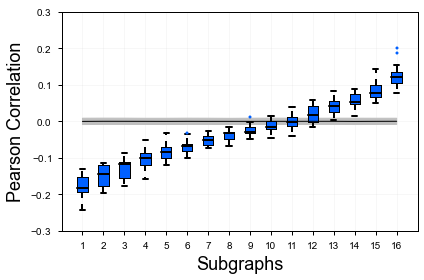

In [12]:
topo_sens_pop_sorted = np.sort(topo_sens_pop, axis=1)
topo_sens_pop_null_sorted = np.sort(topo_sens_pop_null, axis=1).reshape(n_subj*n_null, n_fac)
topo_sens_pop_ord = np.argsort(topo_sens_pop, axis=1)

for ii in xrange(n_fac):
    print('{}-{}'.format(ii+1, stats.ttest_ind(topo_sens_pop_sorted[:, ii],
                                              topo_sens_pop_null_sorted[:, ii])))

# Plot Topographical Sensitivity
plt.figure()
ax = plt.subplot(111)

ax.plot(np.arange(1, n_fac+1),
        np.percentile(topo_sens_pop_null_sorted, 50, axis=0),
        color='k', linewidth=1.0)
ax.fill_between(np.arange(1, 17),
                y1=np.percentile(topo_sens_pop_null_sorted, 25, axis=0),
                y2=np.percentile(topo_sens_pop_null_sorted, 75, axis=0),
                color=[0.75, 0.75, 0.75])

clr_list = []
for ii in xrange(n_fac):
    clr_list.append([0.0, 0.375, 1.0])
bplot = ax.boxplot(topo_sens_pop_sorted, patch_artist=True);
fig_plotting.set_box_color(bplot, 'k', clr_list)

# Axis Settings
ax.set_xlim([0, 17])
ax.yaxis.set_ticks_position('left')
ax.xaxis.set_ticks_position('bottom')
ax.set_ylabel('Pearson Correlation');
ax.set_xlabel('Subgraphs');

plt.savefig('./e04-Figures/Topographic_Sensitivity-SubgraphPCorr.svg')
plt.show()
plt.close()              

### Compute Subgraph Dynamics

In [77]:
tmpr_enrg_pop = np.zeros((n_subj, n_fac))
tmpr_flex_pop = np.zeros((n_subj, n_fac))
tmpr_skew_pop = np.zeros((n_subj, n_fac))

for subj_i in xrange(n_subj):
    for ii, fac_i in enumerate(topo_sens_pop_ord[subj_i, :]):
        fac_subgraph_norm = fac_subgraph_pop[subj_i][fac_i, :] / fac_subgraph_pop[subj_i][fac_i, :].max()
        fac_coef_norm = fac_coef_pop[subj_i][fac_i, :] / fac_coef_pop[subj_i][fac_i, :].max()
                        
        # Temporal energy
        tmpr_enrg = np.mean(fac_coef_norm ** 2)
        tmpr_enrg_pop[subj_i, ii] = tmpr_enrg
        
        # Temporal flexibility
        tmpr_flex = np.mean(np.abs(np.diff(fac_coef_norm)))
        tmpr_flex_pop[subj_i, ii] = tmpr_flex
        
        # Temporal skew
        tmpr_skew = stats.skew(fac_coef_norm)
        tmpr_skew_pop[subj_i, ii] = tmpr_skew        

### Relate Subgraph Dynamics to Topographical Sensitivity

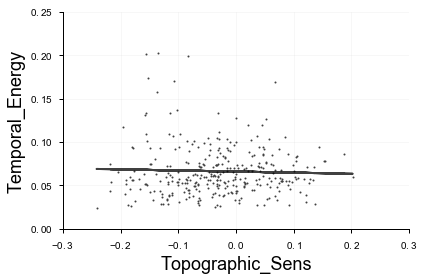

('Topographic_Sens', 'Temporal_Energy', -0.03703843839626849, 0.50912709928128574)


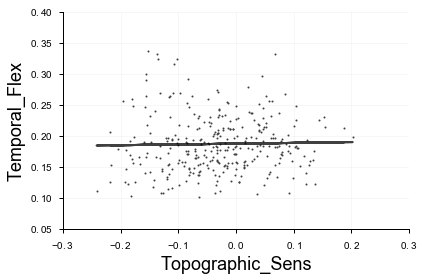

('Topographic_Sens', 'Temporal_Flex', 0.023352650738852915, 0.67728786337717484)


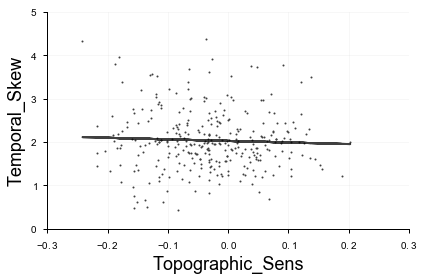

('Topographic_Sens', 'Temporal_Skew', -0.045542495577230911, 0.41683628442184639)


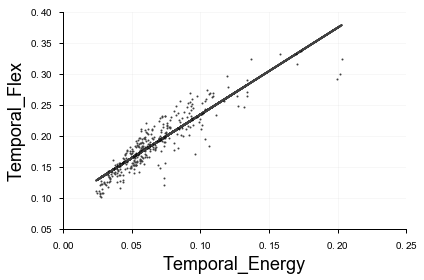

('Temporal_Energy', 'Temporal_Flex', 0.89871164175655838, 7.1678814030148932e-116)


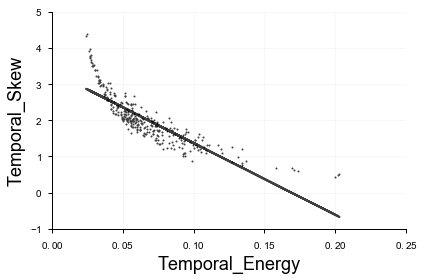

('Temporal_Energy', 'Temporal_Skew', -0.84667579066405896, 3.8936280259803714e-89)


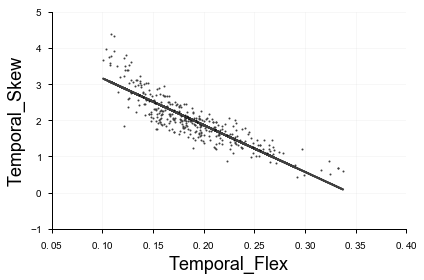

('Temporal_Flex', 'Temporal_Skew', -0.86271640771777691, 3.5379081648461352e-96)


In [78]:
topo_props = [('Topographic_Sens',   topo_sens_pop_sorted),
              ('Temporal_Energy',    tmpr_enrg_pop),
              ('Temporal_Flex',      tmpr_flex_pop),
              ('Temporal_Skew',      tmpr_skew_pop)]

pairs = []
for topo_1 in topo_props:
    for topo_2 in topo_props:
        
        if (topo_2, topo_1) in pairs:
            continue
            
        if topo_1 == topo_2:
            continue
        
        plt.figure()        
        ax = plt.subplot(111)
                
        ax.scatter(topo_1[1], topo_2[1], color=[0.25, 0.25, 0.25], s=1.0)
        m, b, rho, pval, stderr = stats.linregress(topo_1[1].reshape(-1), topo_2[1].reshape(-1))
        ax.plot(topo_1[1].reshape(-1), m*topo_1[1].reshape(-1)+b, color='k', alpha=0.75)
                
        # Axis Settings
        ax.yaxis.set_ticks_position('left')
        ax.xaxis.set_ticks_position('bottom')
        ax.set_xlabel(topo_1[0]);
        ax.set_ylabel(topo_2[0]);

        plt.savefig('./e04-Figures/{}-{}.svg'.format(topo_1[0], topo_2[0]))
        plt.show()
        plt.close()          
        
        print(topo_1[0], topo_2[0], rho, pval)
        
        pairs.append((topo_1, topo_2))